<a href="https://colab.research.google.com/github/ixd-ai-hub/Research-Ground/blob/project%2FCU-865d7na0b-chat-emotion-analyzer/MELD_EDA_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Utils

#### Libraries

In [1]:
! pip install plotly

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import functools
from copy import deepcopy
from collections import Counter, defaultdict
from datetime import time, timedelta, datetime
from typing import List, Dict, Any

import pandas as pd
import numpy as np
from statistics import mode
from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt

#### Functions

In [5]:
# Decorator function
def add_labels_and_title(title, x_label, y_label):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            # Call the original function to create the plot
            plot = func(*args, **kwargs)

            # Add labels and title
            plt.xlabel(x_label)
            plt.ylabel(y_label)
            plt.title(title)

            return plot  # Return the plot with labels and title

        return wrapper
    return decorator

In [6]:
def plot_hist(df: pd.DataFrame, column: str, x_label: str="", y_label: str="", title: str="") -> None:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=column, bins=50)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()


# General Data Statistics

## Initialization

In [7]:
# File path
file_path ="/content/drive/MyDrive/MELD_folder/MELD_test_sent_emo.csv"

In [8]:
# reading csv file
df = pd.read_csv(file_path)
df.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,Why do all you’re coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378"
1,2,Oh. That’s so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385"
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520"
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146"
4,20,Push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833"


## Info about the dataframe

In [13]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 2610 rows and 11 columns


In [14]:
print(f"data table columns : {df.columns}")

data table columns : Index(['Sr No.', 'Utterance', 'Speaker', 'Emotion', 'Sentiment', 'Dialogue_ID',
       'Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime'],
      dtype='object')


Column Specification

| Column Name  | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
|--------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Sr No.       | Serial numbers of the utterances mainly for referencing the utterances in case of different versions or multiple copies with different subsets |
| Utterance    | Individual utterances from EmotionLines as a string.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| Speaker      | Name of the speaker associated with the utterance.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| Emotion      | The emotion (neutral, joy, sadness, anger, surprise, fear, disgust) expressed by the speaker in the utterance.                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| Sentiment    | The sentiment (positive, neutral, negative) expressed by the speaker in the utterance.                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| Dialogue_ID  | The index of the dialogue starting from 0.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| Utterance_ID | The index of the particular utterance in the dialogue starting from 0.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| Season       | The season no. of Friends TV Show to which a particular utterance belongs.                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| Episode      | The episode no. of Friends TV Show in a particular season to which the utterance belongs.                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| StartTime    | The starting time of the utterance in the given episode in the format 'hh:mm:ss,ms'.                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| EndTime      | The ending time of the utterance in the given episode in the format 'hh:mm:ss,ms'.                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        2610 non-null   int64 
 1   Utterance     2610 non-null   object
 2   Speaker       2610 non-null   object
 3   Emotion       2610 non-null   object
 4   Sentiment     2610 non-null   object
 5   Dialogue_ID   2610 non-null   int64 
 6   Utterance_ID  2610 non-null   int64 
 7   Season        2610 non-null   int64 
 8   Episode       2610 non-null   int64 
 9   StartTime     2610 non-null   object
 10  EndTime       2610 non-null   object
dtypes: int64(5), object(6)
memory usage: 224.4+ KB


In [16]:
# categorical column with there unique value counts
df[['Emotion','Sentiment','Speaker','Utterance']].nunique()

Emotion         7
Sentiment       3
Speaker       100
Utterance    2398
dtype: int64

## Add Additional Data Columns

In [17]:
def prep_level1(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    date_format = "%H:%M:%S"
    df['StartTime'] = df['StartTime'].apply(lambda x: datetime.strptime(x.split(',')[0], date_format))
    df['EndTime'] = df['EndTime'].apply(lambda x: datetime.strptime(x.split(',')[0], date_format))

    # number of words uttered
    df["words_uttered"] = df["Utterance"].apply(lambda sentnece: len(sentnece.split()))
    # utterance time
    df['utterance_time(ms)'] = (df.EndTime - df.StartTime).dt.total_seconds()*1000
    # response time
    df.sort_values(by=['Dialogue_ID','StartTime'], inplace=True)
    df['response_time'] = df.groupby("Dialogue_ID")['StartTime'].shift(1)
    time_difference = (df['StartTime'] - df['response_time']).dt.total_seconds()*1000
    df['reply_waiting_time(ms)'] = time_difference.sub(df['utterance_time(ms)']) .abs()  # TODO : check why negative values getting
    df['reply_waiting_time(ms)'] = df['reply_waiting_time(ms)'].fillna(0)
    return df


In [18]:
prep1_df = prep_level1(df)
prep1_df.head(5)

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,words_uttered,utterance_time(ms),response_time,reply_waiting_time(ms)
0,1,Why do all you’re coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,1900-01-01 00:14:38,1900-01-01 00:14:40,11,2000.0,NaT,0.0
1,2,Oh. That’s so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,1900-01-01 00:14:40,1900-01-01 00:14:47,22,7000.0,1900-01-01 00:14:38,5000.0
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,1900-01-01 00:14:56,1900-01-01 00:14:57,2,1000.0,1900-01-01 00:14:40,15000.0
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,1900-01-01 00:10:44,1900-01-01 00:10:46,7,2000.0,NaT,0.0
4,20,Push!,Joey,joy,positive,1,1,1,23,1900-01-01 00:10:46,1900-01-01 00:10:46,1,0.0,1900-01-01 00:10:44,2000.0


## Creating Dialog level dataframe

### Dialog level
#### Distribution plots
* [ ] speakers in a conversation violin plot with box plot
* [ ] utterances in a conversation violin plot with box plot
* [ ] emotions in a conversation histogram
* #sentiments in a conversation histogram
* total conversation time dist. violin plot with box plot
* avg. untt. per person dist. violin plot with box plot
* avg. time between untt. violin plot with box plot


#### Comparison and Correlation plots
* #speakers vs #emotions scatter plot and OLS fit


In [19]:
def most_freq(x):
    return x.value_counts().idxmax()

def get_dialogue_df(df):
    df_copy = df.copy()
    dialogue_df = df_copy.groupby('Dialogue_ID').agg({
        "Utterance": 'size',
        "words_uttered": 'sum',
        "utterance_time(ms)": ['sum', 'mean'],
        "Speaker": 'nunique',
        "Emotion": ['nunique', 'unique', most_freq],
        "Sentiment": ['nunique', 'unique', mode],
    })
    dialogue_df.columns = ['_'.join(col).strip() for col in dialogue_df.columns.values]
    dialogue_df['avg_utterances_per_speaker']=dialogue_df["Utterance_size"]/dialogue_df["Speaker_nunique"]
    return dialogue_df


In [20]:
dialogue_df = get_dialogue_df(prep1_df)
dialogue_df.head()

,Utterance_size,words_uttered_sum,utterance_time(ms)_sum,utterance_time(ms)_mean,Speaker_nunique,Emotion_nunique,Emotion_unique,Emotion_most_freq,Sentiment_nunique,Sentiment_unique,Sentiment_mode,avg_utterances_per_speaker
Dialogue_ID,,,,,,,,,,,,
0,3,35,10000.0,3333.333333,2,3,"[surprise, anger, neutral]",surprise,3,"[positive, negative, neutral]",positive,1.500000
1,8,42,19000.0,2375.000000,1,2,"[neutral, joy]",joy,2,"[neutral, positive]",positive,8.000000
2,11,63,23000.0,2090.909091,2,5,"[neutral, sadness, surprise, anger, joy]",neutral,3,"[neutral, negative, positive]",negative,5.500000
3,7,44,23000.0,3285.714286,3,4,"[neutral, fear, anger, disgust]",neutral,2,"[neutral, negative]",neutral,2.333333
4,9,85,21000.0,2333.333333,3,5,"[surprise, neutral, fear, disgust, anger]",surprise,3,"[positive, neutral, negative]",positive,3.000000


### Visualizations

### utterances amount

In [21]:
import plotly.express as px
import plotly.graph_objects as go

In [22]:
def plot_pdf_box_plot(data, title='', x_axis_label='', y_axis_label=''):
    # Create a PDF plot using a histogram
    fig = px.histogram(data, nbins=50, marginal="box", title=title, labels={x_axis_label, y_axis_label})

    # Update the layout to customize the appearance
    fig.update_layout(
        xaxis_title=x_axis_label,
        yaxis_title=y_axis_label,
        boxmode='overlay',  # Display box plot overlay on the PDF plot
        showlegend=False     # Hide the legend
    )

    # Show the plot
    fig.show()


In [23]:
plot_pdf_box_plot(dialogue_df['Utterance_size'], title='Distribution of No. Utterances per Dialogue', x_axis_label='Number of Utterances', y_axis_label='Frequency')

### Word count

In [24]:
plot_pdf_box_plot(dialogue_df['words_uttered_sum'], title='Distribution of No. words per Dialogue', x_axis_label='Number of Words', y_axis_label='Frequency')

### Time
utterance_time(ms)_sum

In [25]:
plot_pdf_box_plot(dialogue_df['utterance_time(ms)_sum'], title='Distribution of Total Time For Utterances in a Dialogue', x_axis_label='Total Speech Time', y_axis_label='Frequency')

### Parties
Speaker_nunique

In [26]:
plot_pdf_box_plot(dialogue_df['Speaker_nunique'], title='Distribution of No. Speakers per Dialogue', x_axis_label='Number of Speakers in the Dialogue', y_axis_label='Frequency')

### Emotions
Emotion_nunique

In [27]:
plot_pdf_box_plot(dialogue_df['Emotion_nunique'], title='Distribution of No.Unique Emotions per Dialogue', x_axis_label='Total Number of Unique Emotions in the Dialogue', y_axis_label='Frequency')

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Emotion_most_freq', ylabel='count'>

Text(0.5, 1.0, 'Most Frequent Emotions in Dialogues')

Text(0.5, 0, 'Most frequent emotion for a person')

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'neutral'),
  Text(1, 0, 'joy'),
  Text(2, 0, 'anger'),
  Text(3, 0, 'surprise'),
  Text(4, 0, 'sadness'),
  Text(5, 0, 'disgust')])

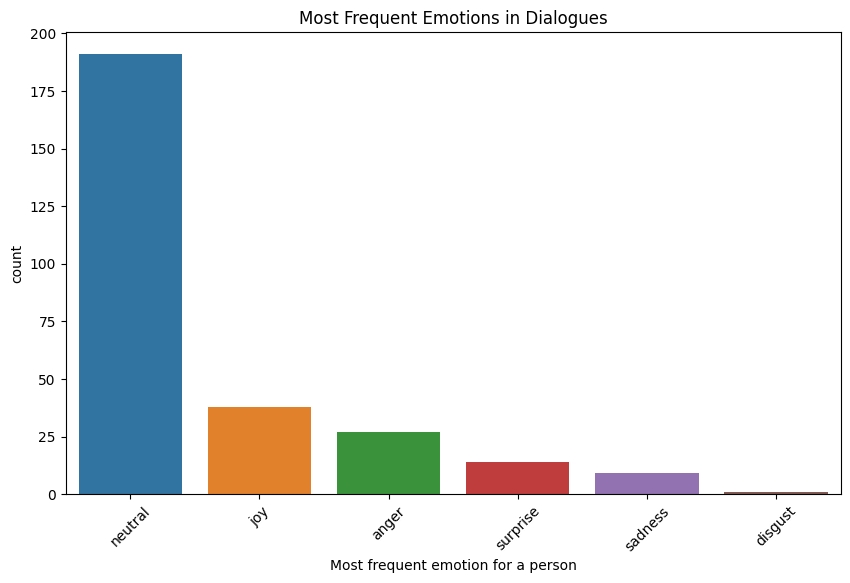

In [28]:
# most frequent emotions in dialogues
plt.figure(figsize=(10, 6))
sns.countplot(data=dialogue_df, x='Emotion_most_freq', order=dialogue_df['Emotion_most_freq'].value_counts().index)
plt.title('Most Frequent Emotions in Dialogues')
plt.xlabel("Most frequent emotion for a person")
plt.xticks(rotation=45)
plt.show()

### Sentiments

<function __main__.add_labels_and_title.<locals>.decorator(func)>

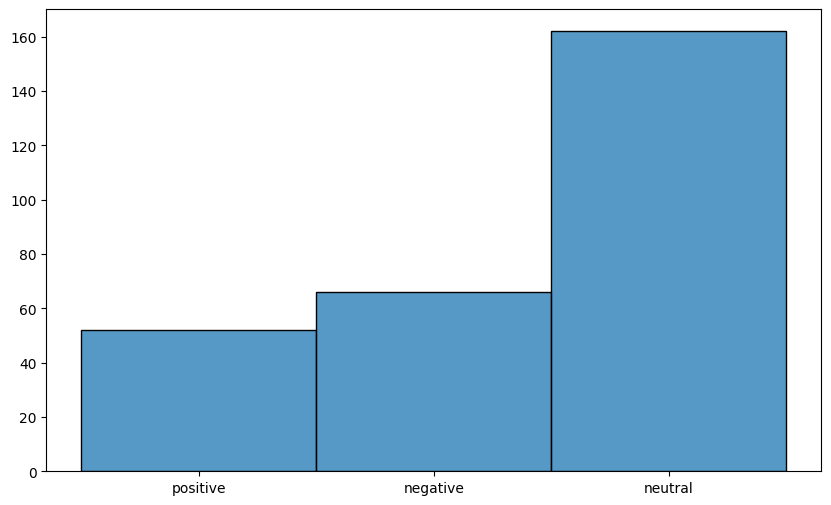

In [29]:
add_labels_and_title('Most Frequent Sentiment in Dialogues', "Sentiment" ,"Frequency")
plot_hist(dialogue_df, "Sentiment_mode")

---

### Utterances per speker ◀

In [30]:
plot_pdf_box_plot(dialogue_df['avg_utterances_per_speaker'], title='Distribution of Number of Utterances per Speaker in a Dialogue', x_axis_label='Utterances per Speaker', y_axis_label='Frequency')

# Utterance Level Stats

### Text length

In [53]:
prep1_df.Utterance.describe()

count     2610
unique    2398
top       Hey!
freq        26
Name: Utterance, dtype: object

### Time

In [54]:
prep1_df.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,words_uttered,utterance_time(ms),response_time,reply_waiting_time(ms)
0,1,Why do all you’re coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,1900-01-01 00:14:38,1900-01-01 00:14:40,11,2000.0,NaT,0.0
1,2,Oh. That’s so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,1900-01-01 00:14:40,1900-01-01 00:14:47,22,7000.0,1900-01-01 00:14:38,5000.0
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,1900-01-01 00:14:56,1900-01-01 00:14:57,2,1000.0,1900-01-01 00:14:40,15000.0
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,1900-01-01 00:10:44,1900-01-01 00:10:46,7,2000.0,NaT,0.0
4,20,Push!,Joey,joy,positive,1,1,1,23,1900-01-01 00:10:46,1900-01-01 00:10:46,1,0.0,1900-01-01 00:10:44,2000.0


#### Utterance time

In [55]:
def df_98(df: pd.DataFrame, col: str) -> pd.DataFrame:
     # Calculate the 98th percentile
    percentile_98 = df[col].quantile(0.98)

    # Filter the values in the 98th percentile
    values_in_percentile_98 = df[df[col] <= percentile_98]
    return values_in_percentile_98

<Axes: xlabel='utterance_time(ms)', ylabel='Density'>

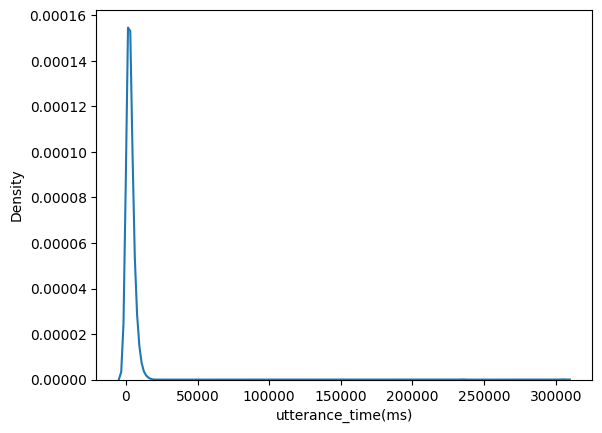

In [56]:
sns.kdeplot(data=prep1_df, x='utterance_time(ms)')

<Axes: xlabel='utterance_time(ms)', ylabel='Density'>

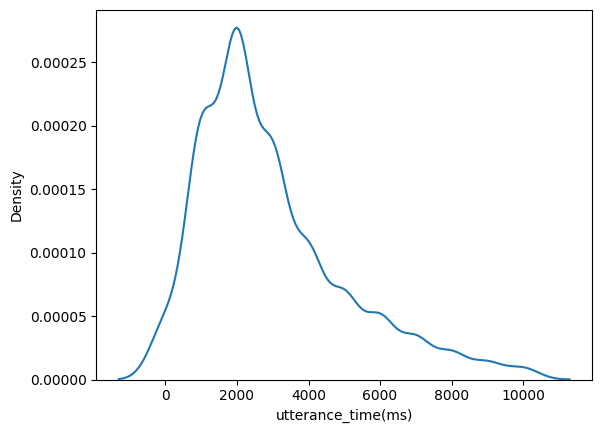

In [57]:
sns.kdeplot(data=df_98(prep1_df, 'utterance_time(ms)'), x='utterance_time(ms)')

<Axes: >

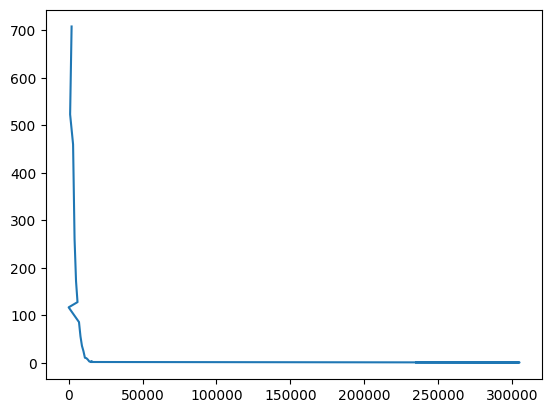

In [58]:
prep1_df["utterance_time(ms)"].value_counts()[:].plot() # XXX

#### Response waiting time PDF

In [59]:
def df_098(df: pd.DataFrame, col: str) -> pd.DataFrame:
    df0 = df.loc[df[col]>0, :]
     # Calculate the 98th percentile
    percentile_98 = df0[col].quantile(0.98)
    # Filter the values in the 98th percentile
    values_in_percentile_98 = df0.loc[df0[col] < percentile_98, :]
    return values_in_percentile_98

<Axes: xlabel='reply_waiting_time(ms)', ylabel='Density'>

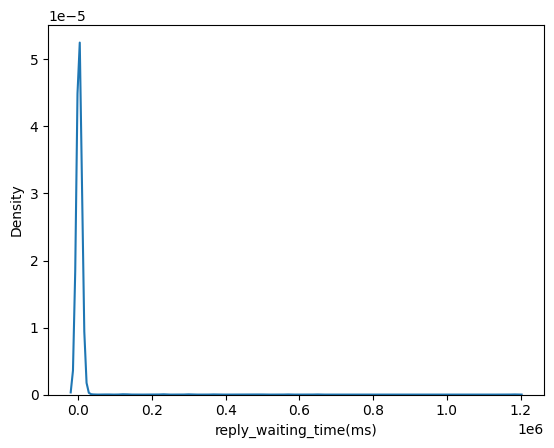

In [60]:
sns.kdeplot(data=prep1_df, x='reply_waiting_time(ms)')

<Axes: xlabel='reply_waiting_time(ms)', ylabel='Density'>

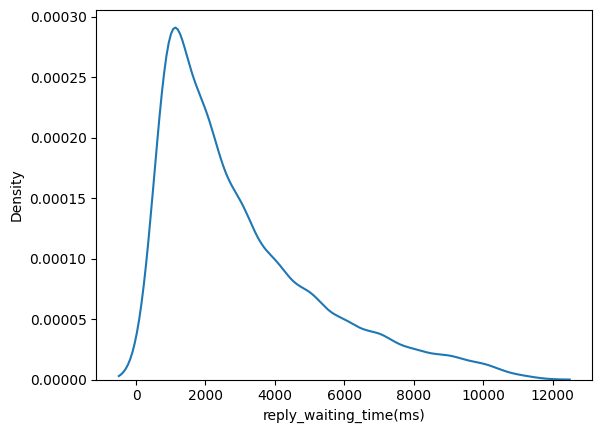

In [61]:
sns.kdeplot(data=df_098(prep1_df, 'reply_waiting_time(ms)'), x='reply_waiting_time(ms)')

### Emotion -> Sentiment mapping

<Axes: xlabel='Emotion', ylabel='Sentiment'>

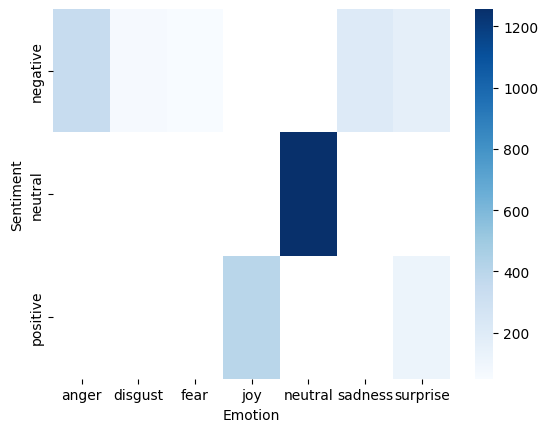

In [62]:
count_df = prep1_df.groupby(['Sentiment', 'Emotion'])['Utterance'].count().reset_index()
table_df = count_df.pivot(index='Sentiment', columns='Emotion')['Utterance']
sns.heatmap(table_df, cmap="Blues")

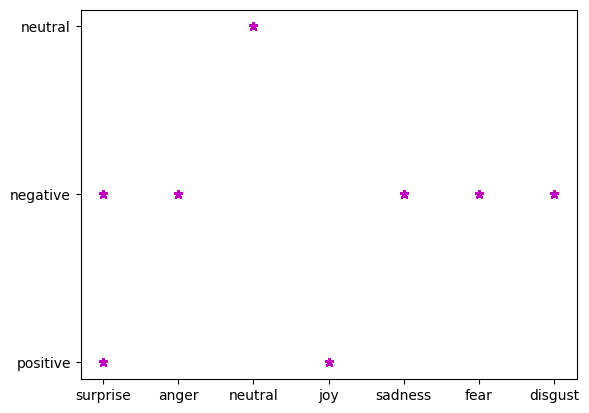

In [63]:
# plotting points as a scatter plot
x = prep1_df["Emotion"]
y = prep1_df["Sentiment"]
# add_labels_and_title("Emotion and Sentiment Mapping", "Emotion","Sentiment")
plt.scatter(x, y, label= "stars", color= "m",
            marker= "*", s=30)

In [64]:
fig = px.sunburst(count_df, path=['Sentiment','Emotion'], values='Utterance', width=500, height=500)
fig.show()

<Axes: title={'center': 'Sentiment and Emotion Division'}, xlabel='Sentiment'>

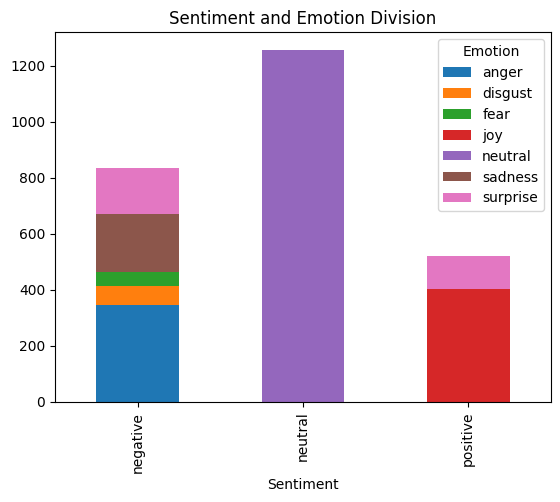

In [65]:
# let's groupby and plot
d = df.groupby(['Sentiment','Emotion'])['Emotion'].size().unstack()
d.plot(kind='bar',stacked=True,title = "Sentiment and Emotion Division")

In [66]:
def plot_pie(df: pd.DataFrame, column: str):
    value_counts = df[column].value_counts()
    # Create a pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Pie Chart of Value Counts')
    plt.show()

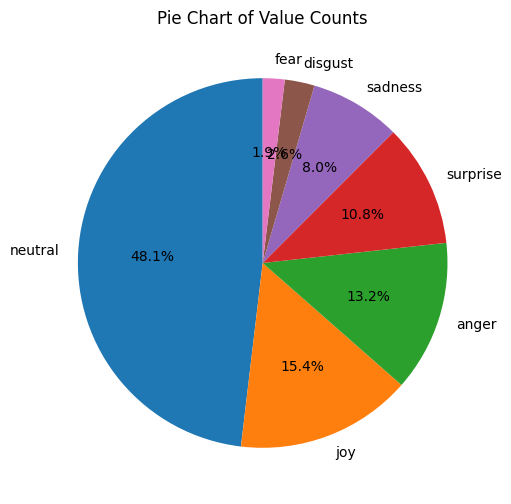

In [67]:
plot_pie(prep1_df, 'Emotion')

neutral     1256
joy          402
anger        345
surprise     281
sadness      208
disgust       68
fear          50
Name: Emotion, dtype: int64


<Axes: >

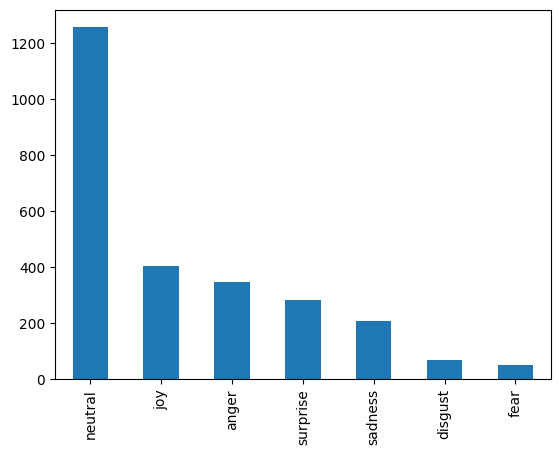

In [68]:
print(prep1_df['Emotion'].value_counts())
df['Emotion'].value_counts()[:].plot.bar()
# df['Emotion'].value_counts()[:].plot.bar(stacked=True)

### Sentiment count

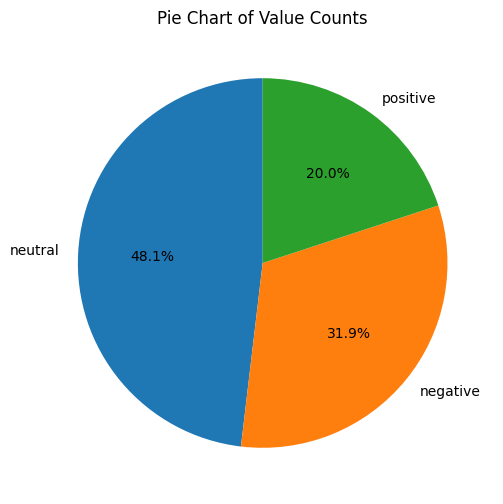

In [69]:
plot_pie(df, 'Sentiment')

neutral     1256
negative     833
positive     521
Name: Sentiment, dtype: int64


<Axes: >

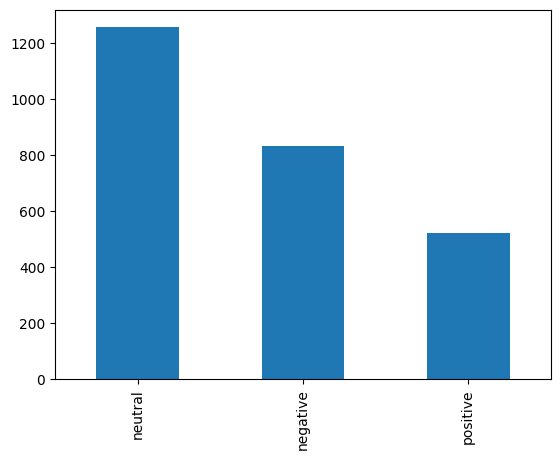

In [70]:
print(df['Sentiment'].value_counts())
df['Sentiment'].value_counts()[:].plot.bar()

In [71]:
df3 = df.groupby(['Emotion']).count().reset_index().sort_values(['Utterance'], ascending=False)[["Emotion", "Utterance"]]

In [72]:
df2 = df.groupby(['Emotion']).count() # XXX
df2.head()

,Sr No.,Utterance,Speaker,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
Emotion,,,,,,,,,,
anger,345,345,345,345,345,345,345,345,345,345
disgust,68,68,68,68,68,68,68,68,68,68
fear,50,50,50,50,50,50,50,50,50,50
joy,402,402,402,402,402,402,402,402,402,402
neutral,1256,1256,1256,1256,1256,1256,1256,1256,1256,1256


In [73]:
# df2 = df.groupby(['Emotion']).count().reset_index().sort_values(['Utterance'], ascending=False)
# df3.plot(kind='pie', y="Utterance",
# figsize=(8,6),
# autopct='%1.1f%%')
# plt.axis('equal')
# # explode = (0, 0, 0,0.1,0.1,0.2,0.3),

In [74]:
df.groupby(['Sentiment']).count()

,Sr No.,Utterance,Speaker,Emotion,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
Sentiment,,,,,,,,,,
negative,833,833,833,833,833,833,833,833,833,833
neutral,1256,1256,1256,1256,1256,1256,1256,1256,1256,1256
positive,521,521,521,521,521,521,521,521,521,521


<Axes: ylabel='Utterance'>

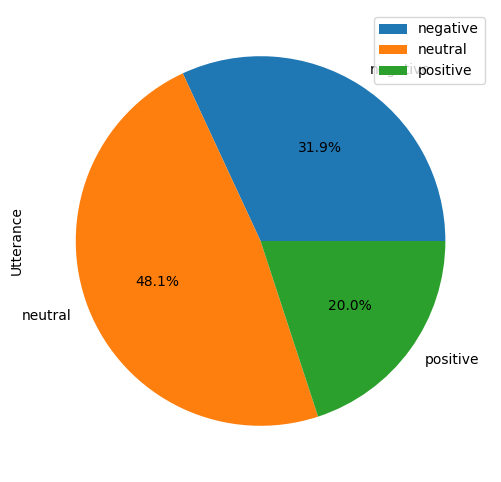

In [75]:
df.groupby(['Sentiment']).count().plot(kind='pie', y='Utterance', figsize=(8,6),autopct='%1.1f%%') # XXX

# Speaker Level Stats

### Personal DF

personal_df;
- [x] person_name
- [x] number of dialogs he/she in
- [x] utt by he/she
- [x] total speech time
- [x] avg. reply time
- [ ] avg. waiting time
- [x] avg. uttr. per dialog
- [ ] all the persons that paired with dialogs
- [x] all emotions he/she shows
- [ ] avg. conti. uttr. span of each emotion

In [47]:
def get_person_df(df):
    df_copy = df.copy()
    personal_df = df_copy.groupby("Speaker").agg({
        'Dialogue_ID': 'nunique',
        'Utterance_ID': 'count',
        'utterance_time(ms)': ['sum', 'mean'],
        'Emotion': ['unique', 'nunique']
    })
    personal_df.columns = ["num_dialogues", "num_utterances", 'total_speech_time', 'average_speech_time', 'emotions_shown', 'num_emotions']
    personal_df['avg_utterances_per_dialogue'] = personal_df['num_utterances']/personal_df['num_dialogues']
    return personal_df

In [48]:
speaker_df = get_person_df(prep1_df)
speaker_df.head()

,num_dialogues,num_utterances,total_speech_time,average_speech_time,emotions_shown,num_emotions,avg_utterances_per_dialogue
Speaker,,,,,,,
A Waiter,1,1,6000.0,6000.0,[neutral],1,1.0
Alan,1,3,9000.0,3000.0,"[surprise, neutral]",2,3.0
All,8,8,14000.0,1750.0,"[neutral, joy, anger]",3,1.0
Bob,1,1,7000.0,7000.0,[joy],1,1.0
Bonnie,2,10,17000.0,1700.0,"[neutral, joy, anger, surprise]",4,5.0


In [49]:
df_copy = speaker_df.copy()
group = df_copy.groupby("Speaker")

****

In [50]:
# num = grou['Dialogue_ID'].nunique()
# num[5:12]p

#### Speaker level plots

##### Number of Dialogues

In [51]:
plot_pdf_box_plot(speaker_df['num_dialogues'], title='Distribution of No.Dialogues by speakers', x_axis_label='Number of Dialogues', y_axis_label='Frequency')

<Axes: xlabel='num_dialogues', ylabel='Density'>

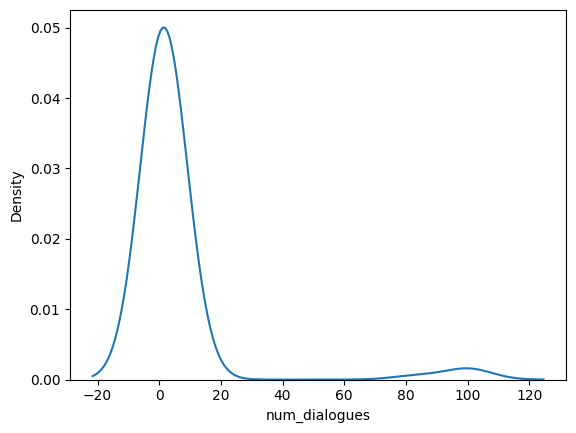

In [76]:
sns.kdeplot(data=df_098(speaker_df, 'num_dialogues'), x='num_dialogues')

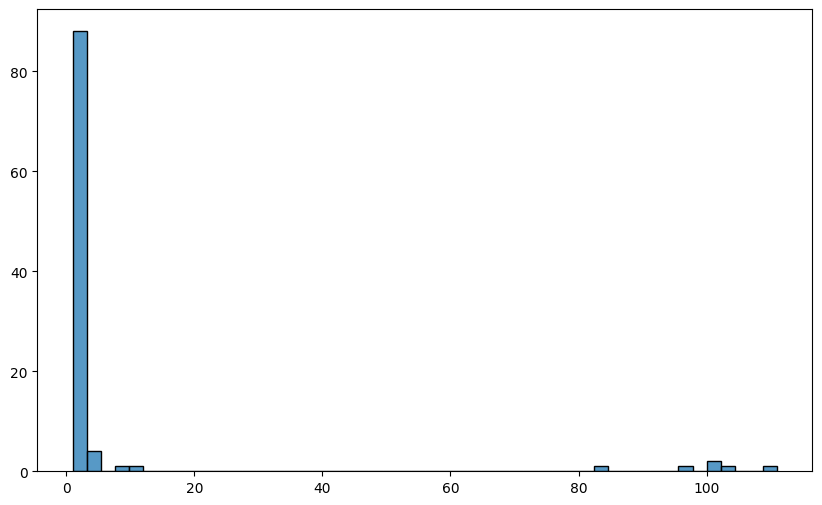

<function __main__.add_labels_and_title.<locals>.decorator(func)>

In [77]:
plot_hist(speaker_df, "num_dialogues")
add_labels_and_title('Distribution of No.Dialogues by speakers', 'Number of Dialogues', "Frequency")

##### Number of utterances

<Axes: xlabel='num_utterances', ylabel='Density'>

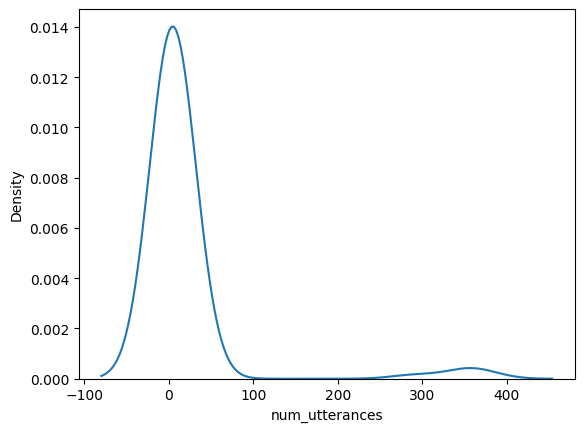

In [78]:
sns.kdeplot(data=df_098(speaker_df, 'num_utterances'), x='num_utterances')

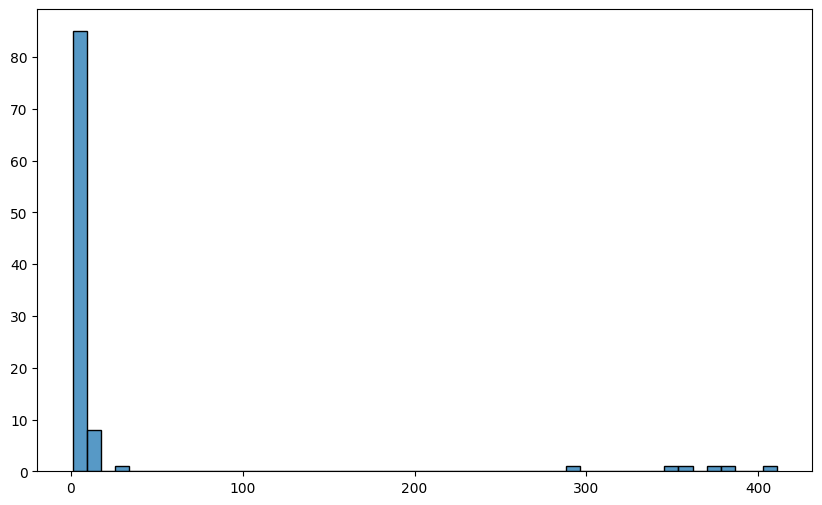

<function __main__.add_labels_and_title.<locals>.decorator(func)>

In [79]:
plot_hist(speaker_df, "num_utterances")
add_labels_and_title('Distribution of No.Utterances by speakers', 'Number of Utterances', "Frequency")


##### Speech time

<Axes: xlabel='total_speech_time', ylabel='Density'>

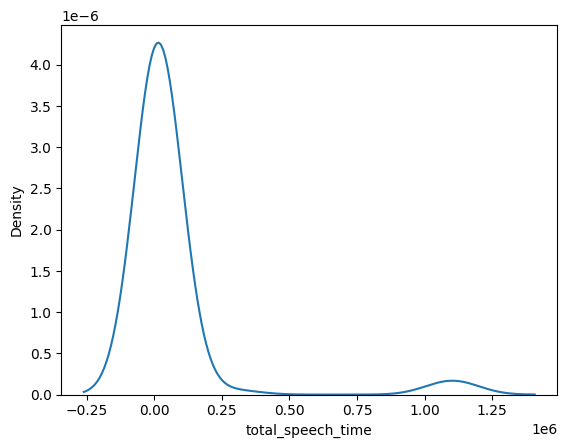

In [80]:
sns.kdeplot(data=df_098(speaker_df, 'total_speech_time'), x='total_speech_time')

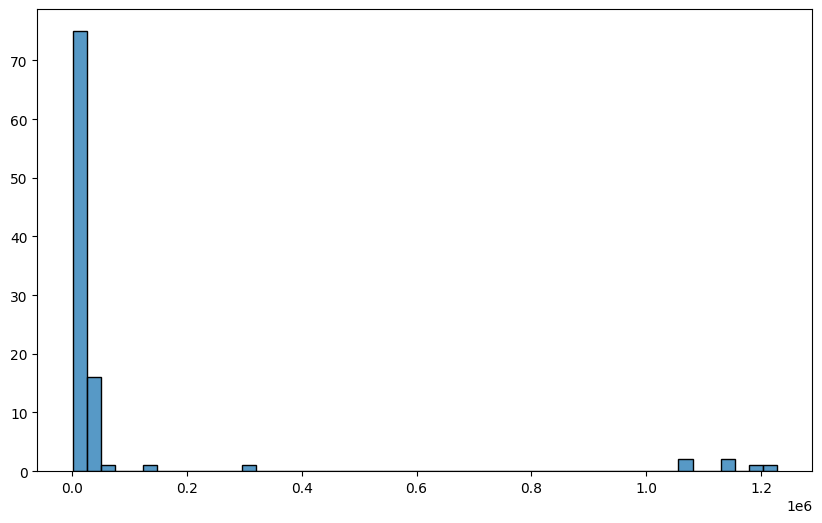

<function __main__.add_labels_and_title.<locals>.decorator(func)>

In [81]:
plot_hist(speaker_df, "total_speech_time")
add_labels_and_title('Distribution of Total Speech Time by speakers', 'Total Speech Time', "Frequency")

##### Number of Emotions Shown by a Single Speaker

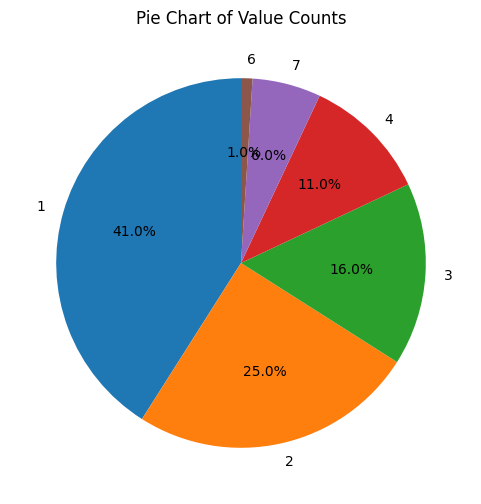

In [82]:
plot_pie(speaker_df, 'num_emotions')

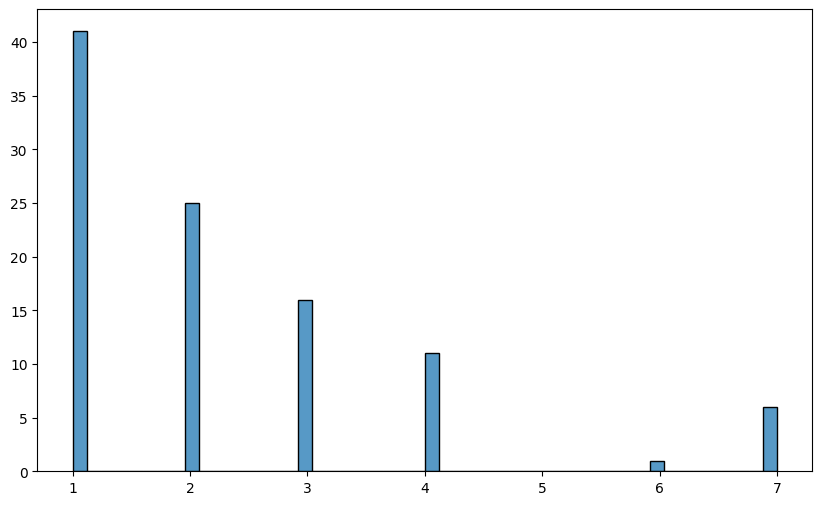

<function __main__.add_labels_and_title.<locals>.decorator(func)>

In [83]:
plot_hist(speaker_df, "num_emotions")
add_labels_and_title('Distribution of No.Dialogues by speakers', 'Total Unique Emotions Shown', "Frequency")

# Emotion Level Stats

## Emotion span

In [96]:
dfcopy = prep1_df.copy()

In [97]:
# Create a group for all dialogueID, speaker and the emotion
df_with_list = dfcopy.groupby(['Dialogue_ID','Speaker'])['Emotion'].apply(list).reset_index()
df_with_list

,Dialogue_ID,Speaker,Emotion
0,0,Mark,[surprise]
1,0,Rachel,"[anger, neutral]"
2,1,Joey,"[neutral, joy, joy, joy, joy, joy, joy, joy]"
3,2,Rachel,"[neutral, anger]"
4,2,Ross,"[neutral, sadness, surprise, anger, anger, joy..."
...,...,...,...
741,278,Monica,"[joy, surprise, joy, joy, joy, neutral]"
742,278,Phoebe,"[surprise, surprise, neutral, neutral]"
743,279,Monica,"[anger, anger, anger, neutral, neutral, anger,..."
744,279,Rachel,"[anger, anger, neutral, neutral, neutral, neut..."


### Before and after emotion & consecutive emotions

In [98]:
def get_emotion_spans(emotion_list: List[str]) -> Dict[str, List]:
    span_dict = defaultdict(list) # output goes here
    # current_emotion = None
    one_before_emotion = None
    last_seen = None
    count = 1

    for i, emotion in enumerate(emotion_list):
        # if the occured value was last seen emotion
        if emotion == last_seen:
            # update the counter
            count +=1
            # print(emotion, count, last_seen)
        else:
            # add the emotion to the list
            #  to check the if this is the first emotion
            if last_seen:
                try:
                    after_emotion = emotion_list[i+1]
                    record = {
                        'count': count,
                        'before': one_before_emotion,
                        'after': after_emotion
                    }
                    # print(emotion, record, last_seen)
                    span_dict[last_seen].append(deepcopy(record))
                    # switcher.get(emotion)(count)

                except:
                    pass
            else: # not the first emotion of the list
                # switcher.get(emotion)(count)
                pass
            # switcher.get(last_seen)(count)
            one_before_emotion = last_seen
            last_seen = emotion
            count = 1
    else: #end of the list
        record = {
                    'count': count,
                    'before': one_before_emotion,
                    'after': None
                }
        span_dict[last_seen].append(deepcopy(record))

    return dict(span_dict)

In [99]:
df_with_dict = df_with_list.copy()
df_with_dict['emotion_span'] = df_with_dict['Emotion'].apply(lambda row: get_emotion_spans(row))
df_with_dict.head()

,Dialogue_ID,Speaker,Emotion,emotion_span
0,0,Mark,[surprise],"{'surprise': [{'count': 1, 'before': None, 'af..."
1,0,Rachel,"[anger, neutral]","{'neutral': [{'count': 1, 'before': 'anger', '..."
2,1,Joey,"[neutral, joy, joy, joy, joy, joy, joy, joy]","{'neutral': [{'count': 1, 'before': None, 'aft..."
3,2,Rachel,"[neutral, anger]","{'anger': [{'count': 1, 'before': 'neutral', '..."
4,2,Ross,"[neutral, sadness, surprise, anger, anger, joy...","{'neutral': [{'count': 1, 'before': None, 'aft..."


#### Most common emotion

In [110]:
def get_most_common(x: Dict):
    count_dict = defaultdict(int)
    for em, arr in x.items():
        total_count = sum([i['count'] for i in arr])
        count_dict[em] = total_count

    sorted_emo = sorted(count_dict.items(), key=lambda x: x[1])
    return sorted_emo[-1][0]

In [111]:
df_with_dict['most_common_emotion'] = df_with_dict['emotion_span'].apply(get_most_common)
df_with_dict.head()

,Dialogue_ID,Speaker,Emotion,emotion_span,most_common_emotion
0,0,Mark,[surprise],"{'surprise': [{'count': 1, 'before': None, 'af...",surprise
1,0,Rachel,"[anger, neutral]","{'neutral': [{'count': 1, 'before': 'anger', '...",neutral
2,1,Joey,"[neutral, joy, joy, joy, joy, joy, joy, joy]","{'neutral': [{'count': 1, 'before': None, 'aft...",joy
3,2,Rachel,"[neutral, anger]","{'anger': [{'count': 1, 'before': 'neutral', '...",anger
4,2,Ross,"[neutral, sadness, surprise, anger, anger, joy...","{'neutral': [{'count': 1, 'before': None, 'aft...",neutral


In [112]:
def get_least_common(x: Dict):
    count_dict = defaultdict(int)
    for em, arr in x.items():
        total_count = sum([i['count'] for i in arr])
        count_dict[em] = total_count

    sorted_emo = sorted(count_dict.items(), key=lambda x: x[1])
    return sorted_emo[0][0]

In [114]:
df_with_dict['least_common_emotion'] = df_with_dict['emotion_span'].apply(get_least_common)
df_with_dict.head()

,Dialogue_ID,Speaker,Emotion,emotion_span,most_common_emotion,least_common_emotion
0,0,Mark,[surprise],"{'surprise': [{'count': 1, 'before': None, 'af...",surprise,surprise
1,0,Rachel,"[anger, neutral]","{'neutral': [{'count': 1, 'before': 'anger', '...",neutral,neutral
2,1,Joey,"[neutral, joy, joy, joy, joy, joy, joy, joy]","{'neutral': [{'count': 1, 'before': None, 'aft...",joy,neutral
3,2,Rachel,"[neutral, anger]","{'anger': [{'count': 1, 'before': 'neutral', '...",anger,anger
4,2,Ross,"[neutral, sadness, surprise, anger, anger, joy...","{'neutral': [{'count': 1, 'before': None, 'aft...",neutral,sadness


In [116]:
def get_max_span(x: Dict):
    count_dict = defaultdict(int)
    for em, arr in x.items():
        max_count = max([i['count'] for i in arr])
        count_dict[em] = max_count

    return count_dict

In [117]:
df_with_dict['max_emotion_span'] = df_with_dict['emotion_span'].apply(get_max_span)
df_with_dict.head()

,Dialogue_ID,Speaker,Emotion,emotion_span,most_common_emotion,least_common_emotion,max_emotion_span
0,0,Mark,[surprise],"{'surprise': [{'count': 1, 'before': None, 'af...",surprise,surprise,{'surprise': 1}
1,0,Rachel,"[anger, neutral]","{'neutral': [{'count': 1, 'before': 'anger', '...",neutral,neutral,{'neutral': 1}
2,1,Joey,"[neutral, joy, joy, joy, joy, joy, joy, joy]","{'neutral': [{'count': 1, 'before': None, 'aft...",joy,neutral,"{'neutral': 1, 'joy': 7}"
3,2,Rachel,"[neutral, anger]","{'anger': [{'count': 1, 'before': 'neutral', '...",anger,anger,{'anger': 1}
4,2,Ross,"[neutral, sadness, surprise, anger, anger, joy...","{'neutral': [{'count': 1, 'before': None, 'aft...",neutral,sadness,"{'neutral': 2, 'sadness': 1, 'surprise': 1, 'a..."


In [118]:
def get_min_span(x: Dict):
    count_dict = defaultdict(int)
    for em, arr in x.items():
        max_count = min([i['count'] for i in arr])
        count_dict[em] = max_count

    return count_dict

In [119]:
df_with_dict['min_emotion_span'] = df_with_dict['emotion_span'].apply(get_min_span)
df_with_dict.head()

,Dialogue_ID,Speaker,Emotion,emotion_span,most_common_emotion,least_common_emotion,max_emotion_span,min_emotion_span
0,0,Mark,[surprise],"{'surprise': [{'count': 1, 'before': None, 'af...",surprise,surprise,{'surprise': 1},{'surprise': 1}
1,0,Rachel,"[anger, neutral]","{'neutral': [{'count': 1, 'before': 'anger', '...",neutral,neutral,{'neutral': 1},{'neutral': 1}
2,1,Joey,"[neutral, joy, joy, joy, joy, joy, joy, joy]","{'neutral': [{'count': 1, 'before': None, 'aft...",joy,neutral,"{'neutral': 1, 'joy': 7}","{'neutral': 1, 'joy': 7}"
3,2,Rachel,"[neutral, anger]","{'anger': [{'count': 1, 'before': 'neutral', '...",anger,anger,{'anger': 1},{'anger': 1}
4,2,Ross,"[neutral, sadness, surprise, anger, anger, joy...","{'neutral': [{'count': 1, 'before': None, 'aft...",neutral,sadness,"{'neutral': 2, 'sadness': 1, 'surprise': 1, 'a...","{'neutral': 1, 'sadness': 1, 'surprise': 1, 'a..."


In [131]:
def get_most_common_defore(x: Dict):
    emo_dict = {}
    for em, arr in x.items():
        defore_emotions = [i['before'] for i in arr if i['before']!=None]
        element_counts = Counter(defore_emotions)
        try:
            most_common_element = element_counts.most_common(1)[0][0]
        except:
            most_common_element = None
        emo_dict[em] = most_common_element

    return emo_dict

In [132]:
df_with_dict['most_common_emotion_defore'] = df_with_dict['emotion_span'].apply(get_most_common_defore)
df_with_dict.head()

,Dialogue_ID,Speaker,Emotion,emotion_span,most_common_emotion,least_common_emotion,max_emotion_span,min_emotion_span,most_common_emotion_defore
0,0,Mark,[surprise],"{'surprise': [{'count': 1, 'before': None, 'af...",surprise,surprise,{'surprise': 1},{'surprise': 1},{'surprise': None}
1,0,Rachel,"[anger, neutral]","{'neutral': [{'count': 1, 'before': 'anger', '...",neutral,neutral,{'neutral': 1},{'neutral': 1},{'neutral': 'anger'}
2,1,Joey,"[neutral, joy, joy, joy, joy, joy, joy, joy]","{'neutral': [{'count': 1, 'before': None, 'aft...",joy,neutral,"{'neutral': 1, 'joy': 7}","{'neutral': 1, 'joy': 7}","{'neutral': None, 'joy': 'neutral'}"
3,2,Rachel,"[neutral, anger]","{'anger': [{'count': 1, 'before': 'neutral', '...",anger,anger,{'anger': 1},{'anger': 1},{'anger': 'neutral'}
4,2,Ross,"[neutral, sadness, surprise, anger, anger, joy...","{'neutral': [{'count': 1, 'before': None, 'aft...",neutral,sadness,"{'neutral': 2, 'sadness': 1, 'surprise': 1, 'a...","{'neutral': 1, 'sadness': 1, 'surprise': 1, 'a...","{'neutral': 'joy', 'sadness': 'neutral', 'surp..."


In [133]:
def get_least_common_defore(x: Dict):
    emo_dict = {}
    for em, arr in x.items():
        defore_emotions = [i['before'] for i in arr if i['before']!=None]
        element_counts = Counter(defore_emotions)
        try:
            least_common_element = element_counts.most_common()[-1][0]
        except:
            least_common_element = None
        emo_dict[em] = least_common_element

    return emo_dict

In [134]:
df_with_dict['least_common_emotion_defore'] = df_with_dict['emotion_span'].apply(get_least_common_defore)
df_with_dict.head()

,Dialogue_ID,Speaker,Emotion,emotion_span,most_common_emotion,least_common_emotion,max_emotion_span,min_emotion_span,most_common_emotion_defore,least_common_emotion_defore
0,0,Mark,[surprise],"{'surprise': [{'count': 1, 'before': None, 'af...",surprise,surprise,{'surprise': 1},{'surprise': 1},{'surprise': None},{'surprise': None}
1,0,Rachel,"[anger, neutral]","{'neutral': [{'count': 1, 'before': 'anger', '...",neutral,neutral,{'neutral': 1},{'neutral': 1},{'neutral': 'anger'},{'neutral': 'anger'}
2,1,Joey,"[neutral, joy, joy, joy, joy, joy, joy, joy]","{'neutral': [{'count': 1, 'before': None, 'aft...",joy,neutral,"{'neutral': 1, 'joy': 7}","{'neutral': 1, 'joy': 7}","{'neutral': None, 'joy': 'neutral'}","{'neutral': None, 'joy': 'neutral'}"
3,2,Rachel,"[neutral, anger]","{'anger': [{'count': 1, 'before': 'neutral', '...",anger,anger,{'anger': 1},{'anger': 1},{'anger': 'neutral'},{'anger': 'neutral'}
4,2,Ross,"[neutral, sadness, surprise, anger, anger, joy...","{'neutral': [{'count': 1, 'before': None, 'aft...",neutral,sadness,"{'neutral': 2, 'sadness': 1, 'surprise': 1, 'a...","{'neutral': 1, 'sadness': 1, 'surprise': 1, 'a...","{'neutral': 'joy', 'sadness': 'neutral', 'surp...","{'neutral': 'joy', 'sadness': 'neutral', 'surp..."


In [137]:
def get_most_common_after(x: Dict):
    emo_dict = {}
    for em, arr in x.items():
        defore_emotions = [i['after'] for i in arr if i['after']!=None]
        element_counts = Counter(defore_emotions)
        try:
            most_common_element = element_counts.most_common(1)[0][0]
        except:
            most_common_element = None
        emo_dict[em] = most_common_element

    return emo_dict

In [138]:
df_with_dict['most_common_emotion_after'] = df_with_dict['emotion_span'].apply(get_most_common_after)
df_with_dict.head()

,Dialogue_ID,Speaker,Emotion,emotion_span,most_common_emotion,least_common_emotion,max_emotion_span,min_emotion_span,most_common_emotion_defore,least_common_emotion_defore,most_common_emotion_after
0,0,Mark,[surprise],"{'surprise': [{'count': 1, 'before': None, 'af...",surprise,surprise,{'surprise': 1},{'surprise': 1},{'surprise': None},{'surprise': None},{'surprise': None}
1,0,Rachel,"[anger, neutral]","{'neutral': [{'count': 1, 'before': 'anger', '...",neutral,neutral,{'neutral': 1},{'neutral': 1},{'neutral': 'anger'},{'neutral': 'anger'},{'neutral': None}
2,1,Joey,"[neutral, joy, joy, joy, joy, joy, joy, joy]","{'neutral': [{'count': 1, 'before': None, 'aft...",joy,neutral,"{'neutral': 1, 'joy': 7}","{'neutral': 1, 'joy': 7}","{'neutral': None, 'joy': 'neutral'}","{'neutral': None, 'joy': 'neutral'}","{'neutral': 'joy', 'joy': None}"
3,2,Rachel,"[neutral, anger]","{'anger': [{'count': 1, 'before': 'neutral', '...",anger,anger,{'anger': 1},{'anger': 1},{'anger': 'neutral'},{'anger': 'neutral'},{'anger': None}
4,2,Ross,"[neutral, sadness, surprise, anger, anger, joy...","{'neutral': [{'count': 1, 'before': None, 'aft...",neutral,sadness,"{'neutral': 2, 'sadness': 1, 'surprise': 1, 'a...","{'neutral': 1, 'sadness': 1, 'surprise': 1, 'a...","{'neutral': 'joy', 'sadness': 'neutral', 'surp...","{'neutral': 'joy', 'sadness': 'neutral', 'surp...","{'neutral': 'surprise', 'sadness': 'anger', 's..."


In [140]:
def get_least_common_after(x: Dict):
    emo_dict = {}
    for em, arr in x.items():
        defore_emotions = [i['after'] for i in arr if i['after']!=None]
        element_counts = Counter(defore_emotions)
        try:
            least_common_element = element_counts.most_common()[-1][0]
        except:
            least_common_element = None
        emo_dict[em] = least_common_element

    return emo_dict

In [141]:
df_with_dict['least_common_emotion_after'] = df_with_dict['emotion_span'].apply(get_least_common_after)
df_with_dict.head()

,Dialogue_ID,Speaker,Emotion,emotion_span,most_common_emotion,least_common_emotion,max_emotion_span,min_emotion_span,most_common_emotion_defore,least_common_emotion_defore,most_common_emotion_after,least_common_emotion_after
0,0,Mark,[surprise],"{'surprise': [{'count': 1, 'before': None, 'af...",surprise,surprise,{'surprise': 1},{'surprise': 1},{'surprise': None},{'surprise': None},{'surprise': None},{'surprise': None}
1,0,Rachel,"[anger, neutral]","{'neutral': [{'count': 1, 'before': 'anger', '...",neutral,neutral,{'neutral': 1},{'neutral': 1},{'neutral': 'anger'},{'neutral': 'anger'},{'neutral': None},{'neutral': None}
2,1,Joey,"[neutral, joy, joy, joy, joy, joy, joy, joy]","{'neutral': [{'count': 1, 'before': None, 'aft...",joy,neutral,"{'neutral': 1, 'joy': 7}","{'neutral': 1, 'joy': 7}","{'neutral': None, 'joy': 'neutral'}","{'neutral': None, 'joy': 'neutral'}","{'neutral': 'joy', 'joy': None}","{'neutral': 'joy', 'joy': None}"
3,2,Rachel,"[neutral, anger]","{'anger': [{'count': 1, 'before': 'neutral', '...",anger,anger,{'anger': 1},{'anger': 1},{'anger': 'neutral'},{'anger': 'neutral'},{'anger': None},{'anger': None}
4,2,Ross,"[neutral, sadness, surprise, anger, anger, joy...","{'neutral': [{'count': 1, 'before': None, 'aft...",neutral,sadness,"{'neutral': 2, 'sadness': 1, 'surprise': 1, 'a...","{'neutral': 1, 'sadness': 1, 'surprise': 1, 'a...","{'neutral': 'joy', 'sadness': 'neutral', 'surp...","{'neutral': 'joy', 'sadness': 'neutral', 'surp...","{'neutral': 'surprise', 'sadness': 'anger', 's...","{'neutral': 'surprise', 'sadness': 'anger', 's..."


In [144]:
df_with_dict.groupby('most_common_emotion')['Dialogue_ID'].nunique()

most_common_emotion
anger        66
disgust      17
fear         11
joy          92
neutral     226
sadness      42
surprise     64
Name: Dialogue_ID, dtype: int64

In [145]:
df_with_dict.groupby('most_common_emotion')['Dialogue_ID'].count()

most_common_emotion
anger        79
disgust      18
fear         11
joy         125
neutral     388
sadness      52
surprise     73
Name: Dialogue_ID, dtype: int64

In [154]:
def expand_dict_column(df, column_name):
    df = df.copy()
    # Use pd.json_normalize to expand the dictionary column
    df_normalized = pd.json_normalize(df[column_name])

    # Concatenate the expanded DataFrame with the original DataFrame, dropping the original dictionary column
    df = pd.concat([df[column_name], df_normalized], axis=1)
    df = df.drop(columns=[column_name])

    return df

In [156]:
expand_dict_column(df_with_dict, 'max_emotion_span').fillna(0).max()

surprise    4.0
neutral     9.0
joy         7.0
anger       7.0
sadness     7.0
fear        2.0
disgust     2.0
dtype: float64

In [157]:
expand_dict_column(df_with_dict, 'min_emotion_span').fillna(0).min()

surprise    0.0
neutral     0.0
joy         0.0
anger       0.0
sadness     0.0
fear        0.0
disgust     0.0
dtype: float64

In [164]:
expand_dict_column(df_with_dict, 'most_common_emotion_defore').mode().iloc[0]

surprise    neutral
neutral         joy
joy         neutral
anger       neutral
sadness     neutral
fear        neutral
disgust     neutral
Name: 0, dtype: object

In [165]:
expand_dict_column(df_with_dict, 'least_common_emotion_defore').mode().iloc[0]

surprise    neutral
neutral         joy
joy         neutral
anger       neutral
sadness     neutral
fear        neutral
disgust     neutral
Name: 0, dtype: object

In [166]:
expand_dict_column(df_with_dict, 'most_common_emotion_after').mode().iloc[0]

surprise    neutral
neutral     neutral
joy         neutral
anger       neutral
sadness     neutral
fear        neutral
disgust     neutral
Name: 0, dtype: object

In [167]:
expand_dict_column(df_with_dict, 'least_common_emotion_after').mode().iloc[0]

surprise    neutral
neutral     neutral
joy         neutral
anger       neutral
sadness     neutral
fear        neutral
disgust     neutral
Name: 0, dtype: object

In [169]:
emotion_df = pd.DataFrame({
    '# convesations this emotion is the most common': df_with_dict.groupby('most_common_emotion')['Dialogue_ID'].nunique(),
    '# users this emotion is the most common': df_with_dict.groupby('most_common_emotion')['Dialogue_ID'].count(),
    'max emotion span': expand_dict_column(df_with_dict, 'max_emotion_span').fillna(0).max(),
    'most common emotion before': expand_dict_column(df_with_dict, 'most_common_emotion_defore').mode().iloc[0],
    'least common emotion before': expand_dict_column(df_with_dict, 'least_common_emotion_defore').mode().iloc[0],
    'most common emotion after': expand_dict_column(df_with_dict, 'most_common_emotion_after').mode().iloc[0],
    'least common emotion after': expand_dict_column(df_with_dict, 'least_common_emotion_after').mode().iloc[0]
})
emotion_df.head()

,# convesations this emotion is the most common,# users this emotion is the most common,max emotion span,most common emotion before,least common emotion before,most common emotion after,least common emotion after
anger,66,79,7.0,neutral,neutral,neutral,neutral
disgust,17,18,2.0,neutral,neutral,neutral,neutral
fear,11,11,2.0,neutral,neutral,neutral,neutral
joy,92,125,7.0,neutral,neutral,neutral,neutral
neutral,226,388,9.0,joy,joy,neutral,neutral


## Emotion DF

- [ ] emotion_df;
    - [x] emotion_name
    - [x] uttr.
    - [x] persons showed
    - [x] dialog that this is the most popular
    - [x] max. cont. span of the emotion
    - [ ] avg. """""
    - [x]  min. """""
    - [x] most common emotion after
    - [x] most common emotion before
    - [ ] most common replying party motion to this
    - [x] least common emotion after
    - [x] least common emotion before
    - [ ] least common replying party motion to this

# Emotion Analysis

Emotion Transitions:
- transitions between emotions for each speaker's utterance.
  - sudden shifts
  - gradual transitions
  - repeated emotional

Intensity

Emotion Dynamics:
- converge to same
- diverge

Turn-Taking and Emotions:
- emotions change during turn-taking between speakers.
  - does not change during turn-taking
  - changes

Contextual Triggers:
- Specific words, topics, or events trigger emotional changes.

Long-Term Trends:
Speaker-Specific Patterns:

Emotional Resonance:
- speaker's emotion seems to resonate with the other
  - ex: empathetic responses or emotional contagion.

Dialogue Arcs:
Look for narrative arcs within the dialogue. Do emotions follow a rising-falling pattern, similar to a story's structure?

Social Dynamics:
- emotions change in relation to
  - power dynamics
  - social roles
  - relationships

- emotion change with the situation
  certain emotions emerge during moments of
  - conflict
  - agreement
  - negotiation







---
speakers per dialogue
avg of uttarance
gap between two utterences
time taken by speaker to reply
speaker and their emotions/sentiment distribution


We observe that the number of such
emotion shifts in successive utterances of a speaker
in a dialogue is very frequent: 4003, 427, and 1003
in train/dev/test splits, respectively